This tutorial focuses on preparing ***the power spectral density (PSD) estimated by seqARIMA noise subtraction filter***.

`beacon` will be aliased as `bc` in the code snippets.

In [1]:
import beacon as bc

/opt/miniconda3/envs/BEACON/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


# Loading GW data & preprocessing

## Load data
There are two data formats commonly used in GW data analysis: Frame format (.gwf) and HDF5 format (.h5 or .hdf5).
`beacon` package only supports HDF5 format for loading data at the moment, so GWF files need to be loaded using `gwpy` or `pycbc` package.
Here, **HDF5** format is used for demonstration.

In [ ]:
# Change these paths as your file directory!
H1_hdf5_path = "path/to/file_H1.hdf5"
L1_hdf5_path = "path/to/file_H1.hdf5"

strain_H1 = bc.IO.read_H5(H1_hdf5_path, sampling_freq=4096)
strain_L1 = bc.IO.read_H5(L1_hdf5_path, sampling_freq=4096)

In [3]:
type(strain_H1)

beacon.TS.ts

However, if you have GWF files, you can load it by `pycbc` or `gwpy` and then convert it to `beacon.TS.ts` class.
```python
from gwpy.timeseries import TimeSeries
from pycbc.frame import read_frame

gwpy_TS = TimeSeries.read(
    "path/to/gwf/file.gwf", channel="{channel_name}"
)
pycbc_TS = read_frame(
    "path/to/gwf/file.gwf", channels="{channel_name}"
)

# bc.TS.ts() or bc.ts()
ts_from_gwpy = bc.ts.from_gwpy(gwpy_TS)
ts_from_pycbc = bc.ts.from_pycbc(pycbc_TS)
```

## Crop data

For estimating PSD using seqARIMA, it would be better if seqARIMA model fits avoiding the signal time segments.

Let's prepare *noise-only* data and *signal-included* data.

In [ ]:
tgps = 100000000 # Change this!
dur = 32
tstart = int(tgps) - 56 # 56 seconds before the reported gps time (tgps)
tend = tstart + dur  # -56 + 32 = 24 seconds before  the reported gps time (tgps)

noise_H1_win = strain_H1.window(tstart, tend)
noise_L1_win = strain_L1.window(tstart, tend)

strain_H1_win = strain_H1.window(int(tgps) - 16, int(tgps) + 16)
strain_L1_win = strain_L1.window(int(tgps) - 16, int(tgps) + 16)


Let's look at the noise data.

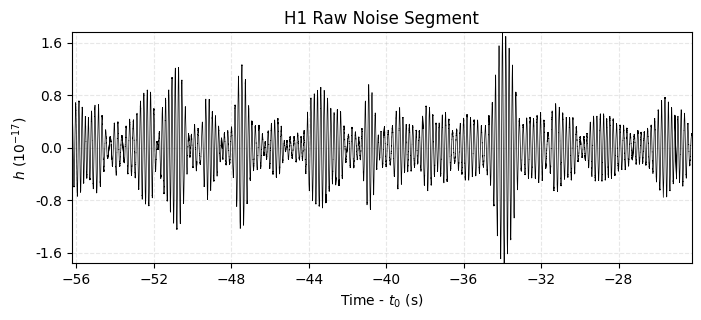

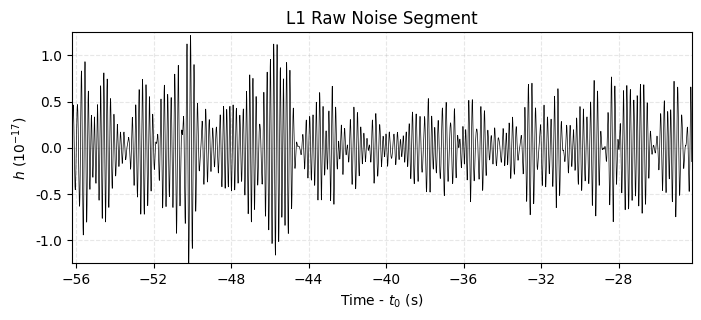

In [5]:
import matplotlib.pyplot as plt
bc.plot.plot_oscillo(
    noise_H1_win,
    tzero=tgps,
    title=f"H1 Raw Noise Segment",
)
plt.show()

bc.plot.plot_oscillo(
    noise_L1_win,
    tzero=tgps,
    title=f"L1 Raw Noise Segment",
)
plt.show()

# Apply seqARIMA

Here, one can try different set of parameters to fit seqARIMA model to the data.
In this demonstration, the following parameters are used:
- `(d, p_max, q_max) = (0, 8192, 3)`: set the maximum AR order to 4096 and EoA order to 3
- with `(fl,fu) = (16, 1024)` Hz in bandpass filter

Here, `q_max` indicates the maximum order of the Ensemble of Average (EoA) smoother. As a default, it ranges q from `1` to `q_max`, and then it performs single moving average (MA) smoothing with order `q` and averages the results for all `q` values. This approach helps to reduce the spectral leackage effect. Details can be found in the [seqARIMA paper](https://arxiv.org/abs/2404.05364).

For choosing `q_max`, it would be better to know what is our target signal frequency range. In this demonstration, we set `q_max=3` to avoid suppressing at $\lt$ 600 Hz.

The guideline for avoiding suppress the signal frequency range is given at the bottom of this tutorial (Appendix 1).

In [6]:
# Setting parameters 
d = None
p_max = 8192
q_max = 3 
low_freq_cutoff = 16 # Hz
upp_freq_cutoff = 1024 # Hz

# Fitting seqARIMA model to noise data
arm_noise_H1 = bc.seqARIMA.seqarima(
    noise_H1_win,
    d=d,
    p=p_max,
    q=range(1, q_max + 1),
    fl=low_freq_cutoff,
    fu=upp_freq_cutoff,
)
arm_noise_L1 = bc.seqARIMA.seqarima(
    noise_L1_win,
    d=d,
    p=p_max,
    q=range(1, q_max + 1),
    fl=low_freq_cutoff,
    fu=upp_freq_cutoff,
)


> Running seqarima...
> (2) Autoregressive stage
|> p=7734 selected!
> (3) Moving-average stage
|> q={ 1, 2, 3 } (collector: median)
> (4) Pass filter stage
|> Band-pass (FIR) filter applied: type=bandpass, order=512, cutoff=(16, 1024) Hz
> Running seqarima...
> (2) Autoregressive stage
|> p=5975 selected!
> (3) Moving-average stage
|> q={ 1, 2, 3 } (collector: median)
> (4) Pass filter stage
|> Band-pass (FIR) filter applied: type=bandpass, order=512, cutoff=(16, 1024) Hz


Then from the fitted seqARIMA model, meta information can be extracted: 
- selected d order 
- AR coefficents corresponding to the selected p
- variance estimated from the AR model

In [7]:
# Extract automatically chosen parameters
param_arm_noise_H1 = bc.seqARIMA.extract_seqarima_params(arm_noise_H1)
param_arm_noise_L1 = bc.seqARIMA.extract_seqarima_params(arm_noise_L1)
print(param_arm_noise_H1)

.(Rist)
    ├── .fs (int)
    │   4096
    ├── .ar_coef (ndarray)
    │   array([ 0.63764756, -0.90250862,  1.49504394, ...,  0.0140012 ,
    │          -0.00687258,  0.00617639])
    ├── .var_pred (float64)
    │   2.4374569370570317e-44
    ├── .q_list (list)
    │   [1, 2, 3]
    ├── .fl (int)
    │   16
    ├── .fu (int)
    │   1024
    └── .bp_order (int)
        512


$^*$ Here, in this demonstration, we don't apply "Differencing", so `d=0`.

Then we are able to estimate PSD from the fitted seqARIMA model.

In [9]:
import numpy as np
# Create FFT frequency samples accordin to the target (signal-included) time segment
freqs_H1 = np.fft.rfftfreq(strain_H1_win.length, 1/4096)
freqs_L1 = np.fft.rfftfreq(strain_L1_win.length, 1/4096)

psd_H1 = bc.seqARIMA.psd_seqarima(freqs_H1, param_arm_noise_H1)
psd_L1 = bc.seqARIMA.psd_seqarima(freqs_L1, param_arm_noise_L1)


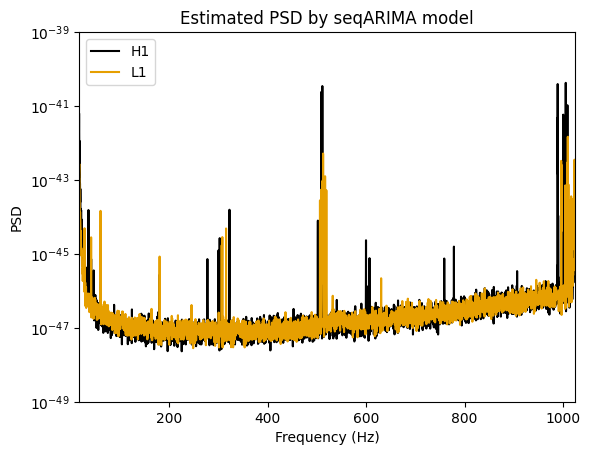

In [15]:
plt.plot(freqs_H1, psd_H1, label="H1")
plt.plot(freqs_L1, psd_L1, label="L1")
plt.xlim(16, 1024)
plt.ylim(1e-49, 1e-39)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.title("Estimated PSD by seqARIMA model")
plt.legend()
plt.semilogy()
plt.show()

In [11]:
welch_psd_H1 = bc.FS.psd(strain_H1_win, seg_len=4, fl=16)
welch_psd_L1 = bc.FS.psd(strain_L1_win, seg_len=4, fl=16)

welch_psd_H1_df = welch_psd_H1.to_df()
welch_psd_L1_df = welch_psd_L1.to_df()


/opt/miniconda3/envs/BEACON/lib/python3.10/site-packages/pycbc/waveform/plugin.py:99: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


lal.MSUN_SI != Msun


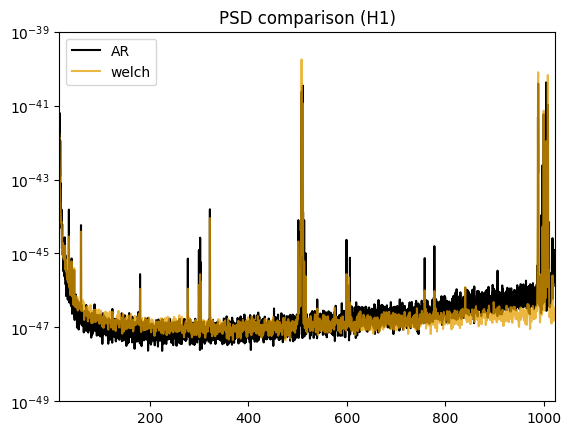

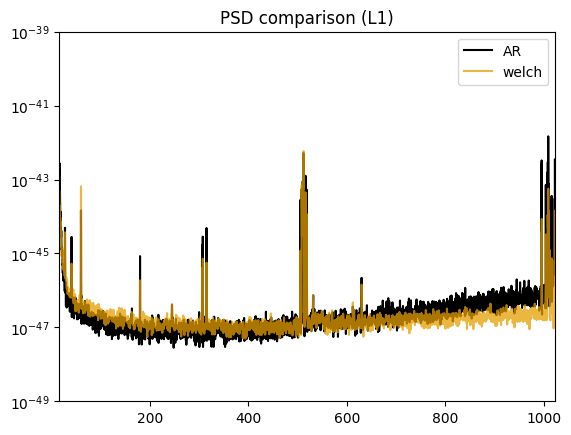

In [13]:
plt.plot(freqs_H1, psd_H1, label="AR")
plt.plot(welch_psd_H1_df["freqs"], welch_psd_H1_df["x"], alpha=0.75, label="welch")
plt.semilogy()
plt.xlim(16, 1024)
plt.ylim(1e-49, 1e-39)
plt.title("PSD comparison (H1)")
plt.legend()
plt.show()

plt.plot(freqs_L1, psd_L1, label="AR")
plt.plot(welch_psd_L1_df["freqs"], welch_psd_L1_df["x"], alpha=0.75, label="welch")
plt.semilogy()
plt.xlim(16, 1024)
plt.ylim(1e-49, 1e-39)
plt.title("PSD comparison (L1)")
plt.legend()
plt.show()


# Save data output

With delimiter of " " (space), the PSD data can be saved as a text file.

In [ ]:
import os
import pandas as pd
if not os.path.exists("Data/PSD"):
    os.makedirs("Data/PSD", exist_ok=True)

pd.DataFrame(psd_H1, freq_H1).to_csv("Data/PSD/PSD_H1_p8k_q3.dat", sep=" ", header=False)
pd.DataFrame(psd_L1, freq_L1).to_csv("Data/PSD/PSD_L1_p8k_q3.dat", sep=" ", header=False)

And also corresponding raw strain data (cropped with 32 seconds around the event time) can be saved as a gwf file.

In [ ]:
gwpy_ts_H1 = strain_H1_win.to_gwpy()
gwpy_ts_L1 = strain_L1_win.to_gwpy()

gwpy_ts_H1.name = "H1:GDS-CALIB_STRAIN_CLEAN"
gwpy_ts_L1.name = "L1:GDS-CALIB_STRAIN_CLEAN"

gwpy_ts_H1.write("Data/Strain_H1.gwf")
gwpy_ts_L1.write("Data/Strain_L1.gwf")


# Appendix

## Upper cutoff frequency of `MA(q)`
The upper cutoff frequency ($f_c$) of `MA(q)` is given by:
$$
f_c \approx \frac{0.443~f_s}{q_{\rm max}}
$$
where $f_s$ is the sampling frequency.
If you choose `q_max=3` with `f_s=4096` Hz, the upper cutoff frequency is approximately `f_c=636.0` Hz.
Please refer to the exact $f_c$ value table below for other `q_max` values.

| `q_max` | $f_c$ |
|---------|-------|
| 2       | 745.6 Hz |
| 3       | 636.0 Hz |
| 4       | 430.2 Hz |
| 5       | 369.3 Hz |
| 6       | 295.3 Hz |
| 7       | 261.5 Hz |
| 8       | 223.8 Hz |
| 9       | 202.7 Hz |
| 10       | 179.9 Hz |
